In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report


In [64]:
%%time 

df_rev = []
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("yelp_academic_dataset_review.json", "r") as dataset:
    reader = pd.read_json(dataset, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=10000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['business_id','review_id', 'user_id']).query("`date` >= '2018-12-01'")
        df_rev.append(reduced_chunk)
    
df_rev = pd.concat(df_rev, ignore_index=True)

CPU times: user 1min 34s, sys: 14.6 s, total: 1min 49s
Wall time: 1min 49s


In [7]:
# show head dataframe
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765254 entries, 0 to 1765253
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   stars   float16       
 1   useful  int32         
 2   funny   int32         
 3   cool    int32         
 4   text    object        
 5   date    datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(1)
memory usage: 50.5+ MB


In [8]:
df_rev.describe()

,stars,useful,funny,cool
count,1765254.0,1.765254e+06,1.765254e+06,1.765254e+06
mean,NaN,8.499236e-01,2.535459e-01,4.561145e-01
std,0.0,3.252142e+00,1.788608e+00,2.820824e+00
min,1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.0,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.0,1.000000e+00,0.000000e+00,0.000000e+00
max,5.0,4.460000e+02,2.880000e+02,3.920000e+02


In [12]:
# Adding a text length for the text field
df_rev['text length'] = df_rev['text'].apply(len)

In [13]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765254 entries, 0 to 1765253
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   stars        float16       
 1   useful       int32         
 2   funny        int32         
 3   cool         int32         
 4   text         object        
 5   date         datetime64[ns]
 6   text length  int64         
dtypes: datetime64[ns](1), float16(1), int32(3), int64(1), object(1)
memory usage: 64.0+ MB


In [14]:
df_rev.head()

,stars,useful,funny,cool,text,date,text length
0,5.0,0,0,0,Vegan donuts! What else can I say!?!? I am so ...,2018-12-04 03:27:14,207
1,5.0,0,0,0,I will definitely be coming back! If you like...,2018-12-02 18:11:06,172
2,3.0,0,0,0,The waiter who greeted me was very helpful and...,2018-12-04 21:13:20,507
3,2.0,0,0,0,Had a salad to go today. Guy behind the counte...,2018-12-10 23:25:48,449
4,4.0,0,0,0,I could honestly spend my whole paycheck here....,2018-12-04 18:39:58,309


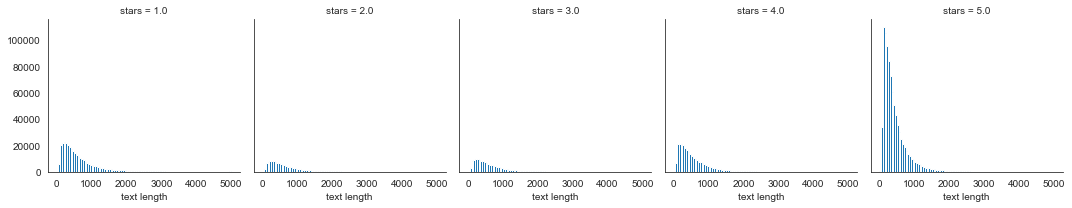

In [17]:
sns.set_style('white')
g1 = sns.FacetGrid(df_rev, col='stars')
g1.map(plt.hist, 'text length', bins=100)

<AxesSubplot:xlabel='stars', ylabel='text length'>

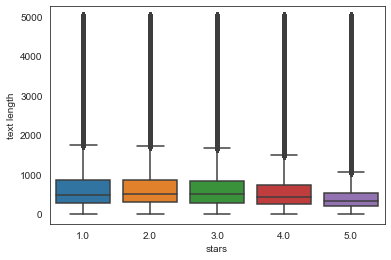

In [18]:
sns.boxplot(x='stars', y='text length', data=df_rev)

<AxesSubplot:>

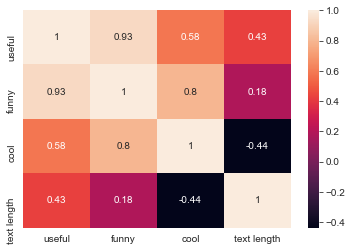

In [22]:
sns.heatmap(df_rev.groupby('stars').mean().corr(), annot=True)

<AxesSubplot:xlabel='stars', ylabel='count'>

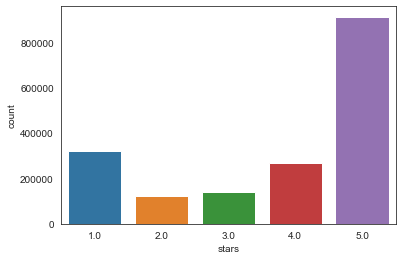

In [47]:
sns.countplot(x='stars', data=df_rev)

In [37]:
df_neg = df_rev[(df_rev['stars']==1) | (df_rev['stars']==2)]
df_neg

,stars,useful,funny,cool,text,date,text length
3,2.0,0,0,0,Had a salad to go today. Guy behind the counte...,2018-12-10 23:25:48,449
8,1.0,0,0,0,Go to any other chili's but this location. Ser...,2018-12-11 04:31:42,542
25,1.0,0,0,0,The food here is reflective of the low prices ...,2018-12-15 02:25:15,244
30,1.0,0,0,0,Although the food and decor of this establishm...,2018-12-02 22:18:01,598
31,1.0,0,0,0,My pizza has literally never shown up 3 times....,2018-12-02 03:07:55,1134
...,...,...,...,...,...,...,...
1765239,2.0,0,0,0,Terrible pho. Literally zero flavor. And the c...,2021-01-17 22:09:10,97
1765247,1.0,1,1,0,This was absolutely the most egregious display...,2020-10-23 23:28:09,1636
1765249,1.0,0,0,0,"In December, I called in (as a returning custo...",2021-01-26 04:07:14,2586
1765250,1.0,13,1,0,This guy is a moron that will stalk and harass...,2019-05-01 21:21:43,407


In [45]:
df_pos = df_rev[(df_rev['stars'] == 3) | (df_rev['stars'] == 4) | (df_rev['stars'] == 5)]
df_pos.describe()

,stars,useful,funny,cool,text length
count,1321179.0,1.321179e+06,1.321179e+06,1.321179e+06,1.321179e+06
mean,NaN,8.221755e-01,2.586130e-01,5.671344e-01,4.834850e+02
std,0.0,3.485058e+00,1.965480e+00,3.194442e+00,4.349510e+02
min,3.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.0,0.000000e+00,0.000000e+00,0.000000e+00,2.050000e+02
50%,5.0,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+02
75%,5.0,1.000000e+00,0.000000e+00,0.000000e+00,6.090000e+02
max,5.0,4.460000e+02,2.880000e+02,3.920000e+02,5.000000e+03


In [48]:
X = df_rev['text']
Y = df_rev['stars']

cv = CountVectorizer()
X = cv.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)


In [49]:
# Multinomial NB
nb = MultinomialNB()


In [52]:
nb.fit(X_train, Y_train)

MultinomialNB()

In [55]:
model = nb.predict(X_test)

In [57]:
print(confusion_matrix(Y_test, model))
print('/n')
print(classification_report(Y_test, model))

[[ 70691  15754   6369   1544   1424]
 [ 11543  10020  11164   3308   1108]
 [  5172   5345  14225  14570   2467]
 [  3349   1932   5709  49654  20398]
 [ 13747   1391   2031  58772 197890]]
/n
              precision    recall  f1-score   support

         1.0       0.68      0.74      0.71     95782
         2.0       0.29      0.27      0.28     37143
         3.0       0.36      0.34      0.35     41779
         4.0       0.39      0.61      0.48     81042
         5.0       0.89      0.72      0.80    273831

    accuracy                           0.65    529577
   macro avg       0.52      0.54      0.52    529577
weighted avg       0.69      0.65      0.66    529577

